# Analysis of the given Dataset

In [14]:
import sys
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/saschaschworm/big-data-and-data-science/master/datasets/prediction-challenge/dataset.csv')

In [15]:
df.head()

,identifier,date,age,marital_status,education,job,credit_default,housing_loan,personal_loan,communication_type,n_contacts_campaign,days_since_last_contact,n_contacts_before,previous_conversion,duration,success
0,34203,2009-05-06,36,divorced,High School,Service provider,No,No,Yes,Landline network,5,-1,0,Inexistent,992,No
1,1250,2008-05-08,32,single,University,Student,No,Yes,No,Landline network,1,-1,0,Inexistent,147,No
2,38130,2009-09-04,68,single,University,Pensioner,No,Yes,No,Celluar phone network,1,-1,0,Inexistent,139,No
3,19300,2008-08-06,39,single,University,Administrator,No,No,No,Celluar phone network,1,-1,0,Inexistent,127,No
4,34497,2009-05-07,30,married,Middle School,Administrator,No,No,No,Celluar phone network,1,-1,1,Failed,586,No


In [16]:
dtypes = pd.DataFrame(df.dtypes.rename('type')).reset_index().astype('str')
# Exclude duration since it is a leaky variable
dtypes = dtypes.query('index != "duration"')
numeric = dtypes[(dtypes.type.isin(['int64', 'float64'])) & (dtypes['index'] != 'duration')]['index'].values
categorical = dtypes[~(dtypes['index'].isin(numeric)) & (dtypes['index'] != 'success')]['index'].values

# Categorical Analysis

## Missing data?

In [17]:
df[categorical].isnull().sum()

date                   0
marital_status         0
education              0
job                    0
credit_default         0
housing_loan           0
personal_loan          0
communication_type     0
previous_conversion    0
dtype: int64

## Values distributed across categorical attributes

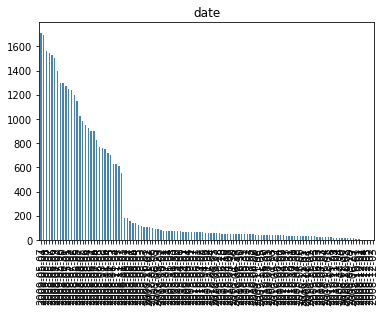

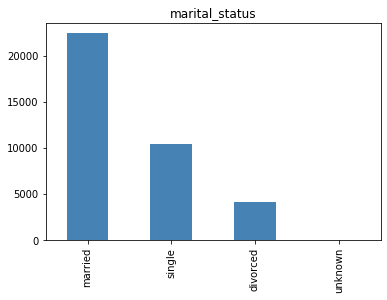

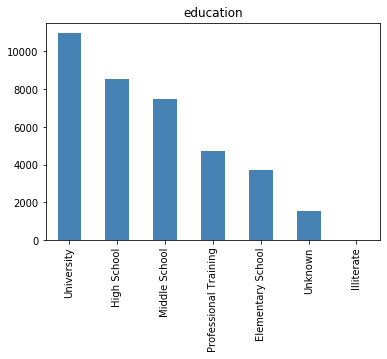

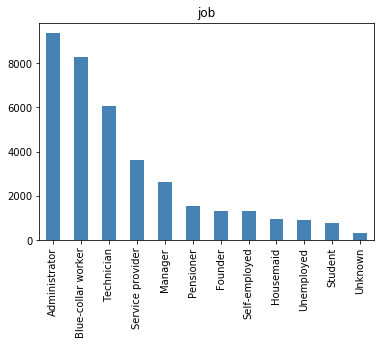

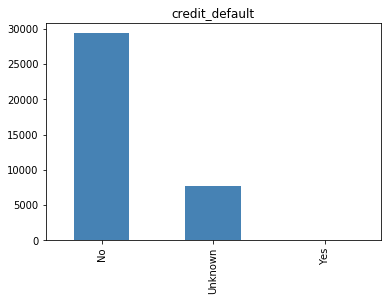

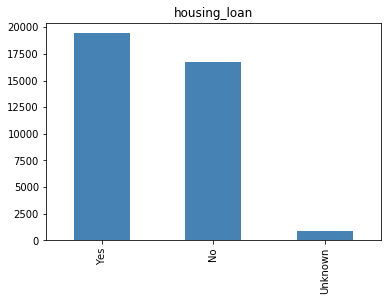

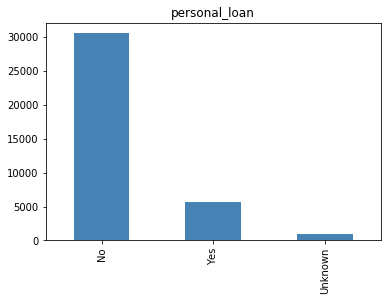

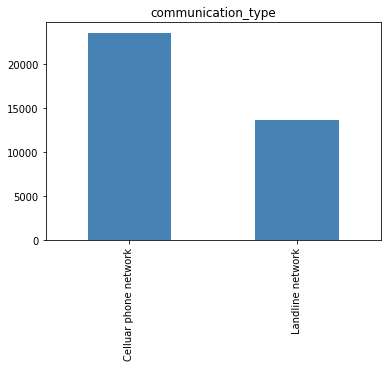

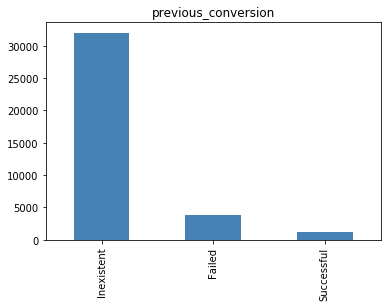

In [18]:
for attr in categorical:
  plt.figure()
  df[attr].value_counts().plot(kind='bar', color='steelblue');
  plt.title(attr);

- No missing data about the marital status, therefore good understanding of it
- No (or very few) customers are illiterate
- No or very few customers who have defaulted on a loan, hereby we can state the fact that the bank probably does not want to extend an offer to a customer with bad credit. But: We have a lot of unknown values. 
- Proportions of customers with / without housing loan are similar
- Few customers have a personal loan
- Double as many celluar as landline phone calls
- Previous conversions mostly failed or (for the most part) are inexistent. Very few were successful
- During the current campaign most of the calls were not successful

Support (date)

2009-05-07    1712
2009-05-04    1696
2009-05-08    1562
2008-05-07    1546
2008-05-06    1532
              ... 
2008-12-01       3
2008-12-04       2
2008-12-05       2
2008-12-02       1
2008-12-03       1
Name: date, Length: 120, dtype: int64 

Support (marital_status)

married     22405
single      10425
divorced     4168
unknown        71
Name: marital_status, dtype: int64 

Support (education)

University               10989
High School               8558
Middle School             7504
Professional Training     4720
Elementary School         3736
Unknown                   1548
Illiterate                  14
Name: education, dtype: int64 

Support (job)

Administrator         9366
Blue-collar worker    8297
Technician            6066
Service provider      3615
Manager               2642
Pensioner             1560
Founder               1315
Self-employed         1298
Housemaid              930
Unemployed             899
Student                784
Unknown           

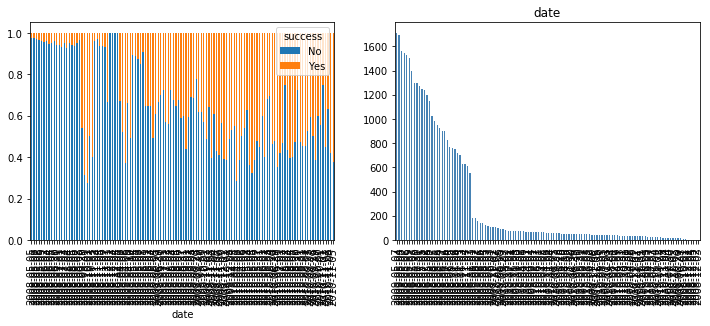

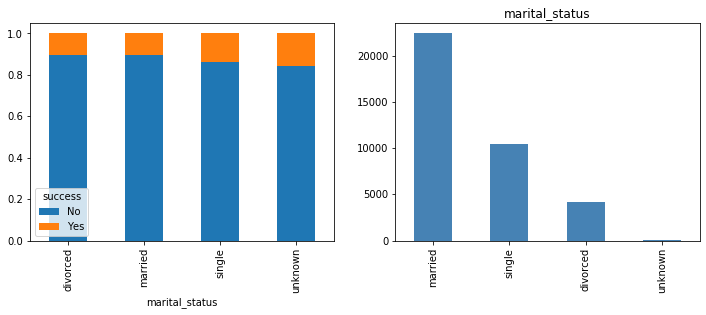

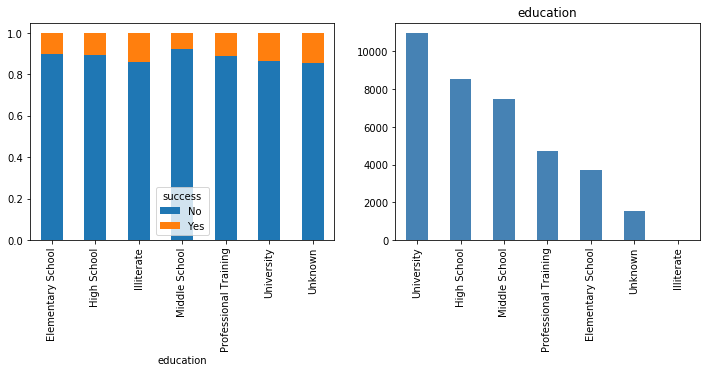

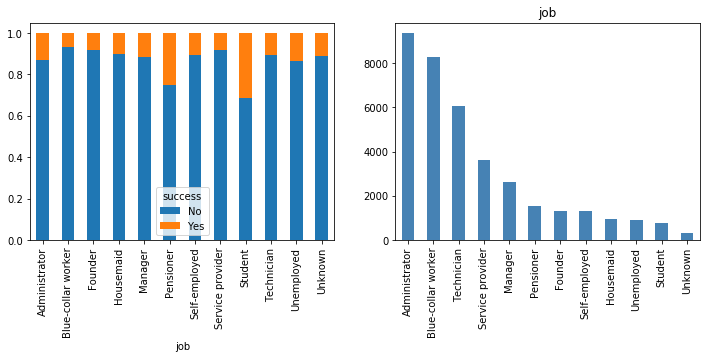

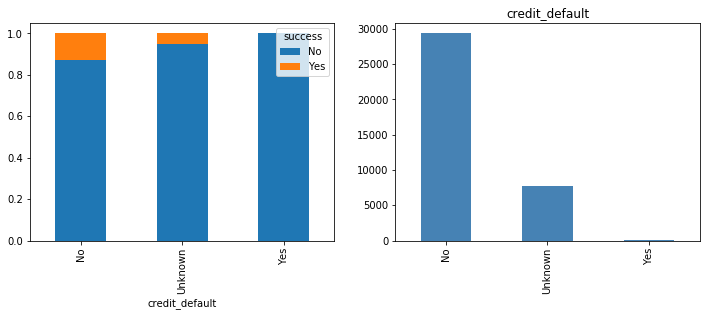

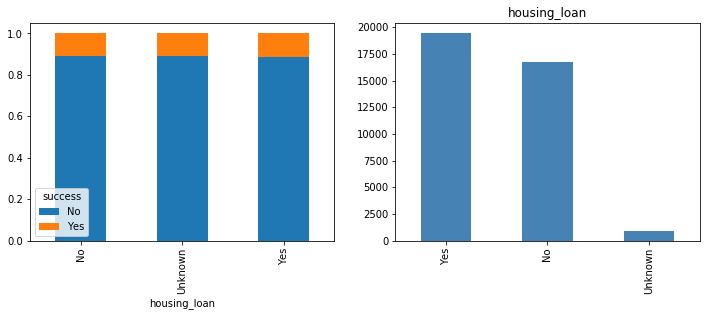

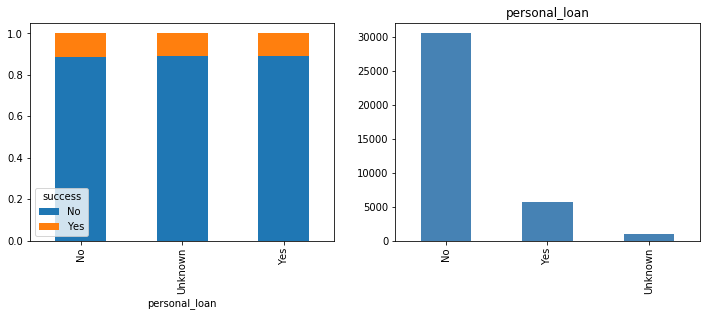

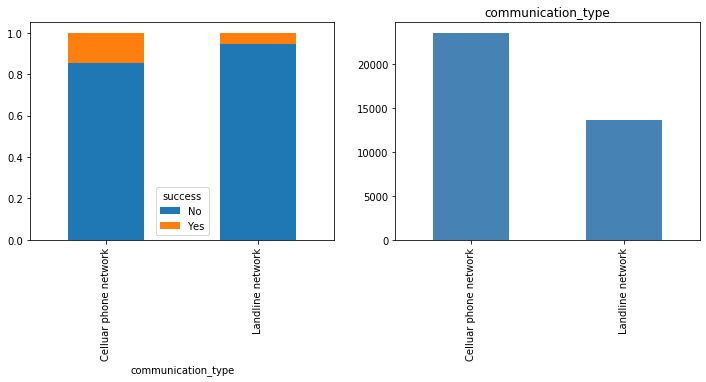

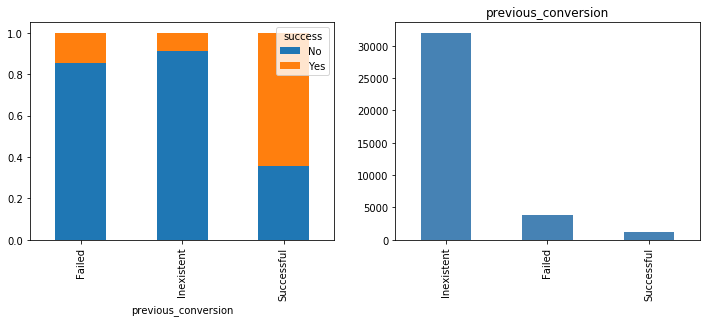

In [19]:
for attr in categorical:
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
  outcome_counts = df.groupby([attr, 'success']).size().rename('count').reset_index()
  by_outcome = outcome_counts.pivot(columns='success', values='count', index=attr)
  # Plot the proportions
  by_outcome.div(by_outcome.sum(1), axis=0).plot.bar(stacked=True, ax=ax1);
  # Plot the counts
  df[attr].value_counts().plot.bar(ax=ax2, legend=False,color='steelblue');
  print('Support (%s)\n' % attr)
  print(df[attr].value_counts(), '\n')
  plt.title(attr);

# Numerical Analysis

## Missing data?

In [20]:
df[numeric].isnull().sum()

identifier                 0
age                        0
n_contacts_campaign        0
days_since_last_contact    0
n_contacts_before          0
dtype: int64

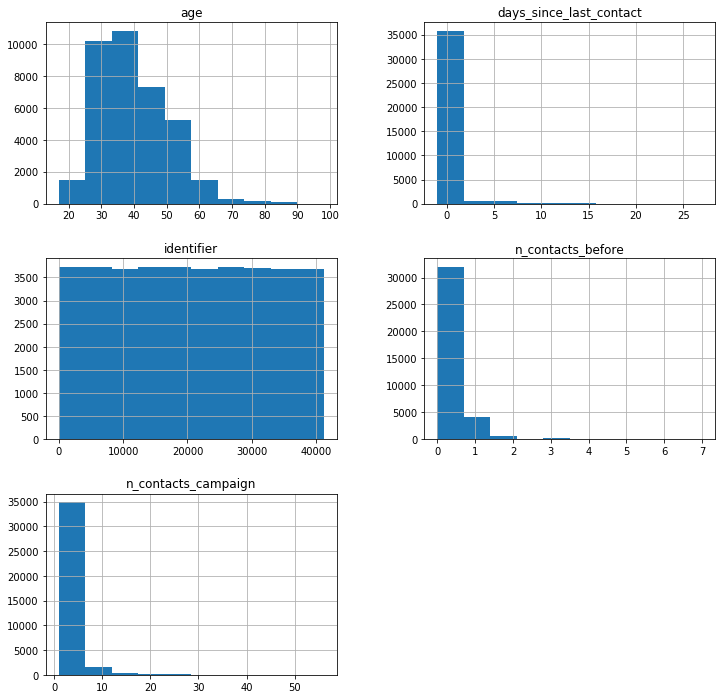

In [21]:
df[numeric].hist(figsize=(12,12));

- The customer age is mostly between 20 and 60, only a few over 60 (variable age)
- The customers were contacted at most a few days ago (variable days_since_last_contact)
- The customers were mostly not contacted about the previous campaign, but also not often contacted about the current campaign

In [22]:
df[numeric].describe()

,identifier,age,n_contacts_campaign,days_since_last_contact,n_contacts_before
count,37069.000000,37069.000000,37069.000000,37069.000000,37069.000000
mean,20558.742615,40.046966,2.571745,-0.742480,0.172004
std,11891.805550,10.449542,2.788895,1.515555,0.492506
min,0.000000,17.000000,1.000000,-1.000000,0.000000
25%,10261.000000,32.000000,1.000000,-1.000000,0.000000
50%,20530.000000,38.000000,2.000000,-1.000000,0.000000
75%,30846.000000,47.000000,3.000000,-1.000000,0.000000
max,41187.000000,98.000000,56.000000,27.000000,7.000000


- Average age of sighted customers: 38
- Contacts during the current campaign on average: 2 times
- Days since last contact: -1, because mostly the customer have not been contacted before. We should not consider the "-1" values and see what happens
- Contacts before current campaign on average: zero times

Hereby we can conclude that days_since_last_contact has an awful lot of customers which value is missing (-1). That can be problematic, is problematic, due to the fact that it manipulates the data. Because few customers have an instance of days_since_last_contact associated we should consider to drop it and see what happens!